In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('daily_weather.csv')

In [4]:
df.head(10)

,date,temperature
0,01/01/2009,-6.810629
1,02/01/2009,-3.360486
2,03/01/2009,5.435694
3,04/01/2009,7.283889
4,05/01/2009,12.690069
5,06/01/2009,15.201597
6,07/01/2009,20.121875
7,08/01/2009,18.864792
8,09/01/2009,21.289722
9,10/01/2009,11.937847


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2923 entries, 0 to 2922
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2923 non-null   object 
 1   temperature  2921 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.8+ KB


In [6]:
# find the rows where the value of 'temperature' is null
rows_with_na = df[df.isnull().any(axis=1)]
rows_with_na.head()

,date,temperature
2855,26/10/2016,NaN
2856,27/10/2016,NaN


In [7]:
# we will fill the missing values using forward fill
df = df.ffill()
rows_with_na = df[df.isnull().any(axis=1)]
rows_with_na.head()

,date,temperature


In [8]:
print(type(df['date'].iloc[0]))
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
print(type(df['date'].iloc[0]))


<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
print(df.index)
df = df.set_index('date')
df.index

RangeIndex(start=0, stop=2923, step=1)


DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=2923, freq=None)

In [10]:
df.index.freq = 'D'

<Axes: xlabel='date'>

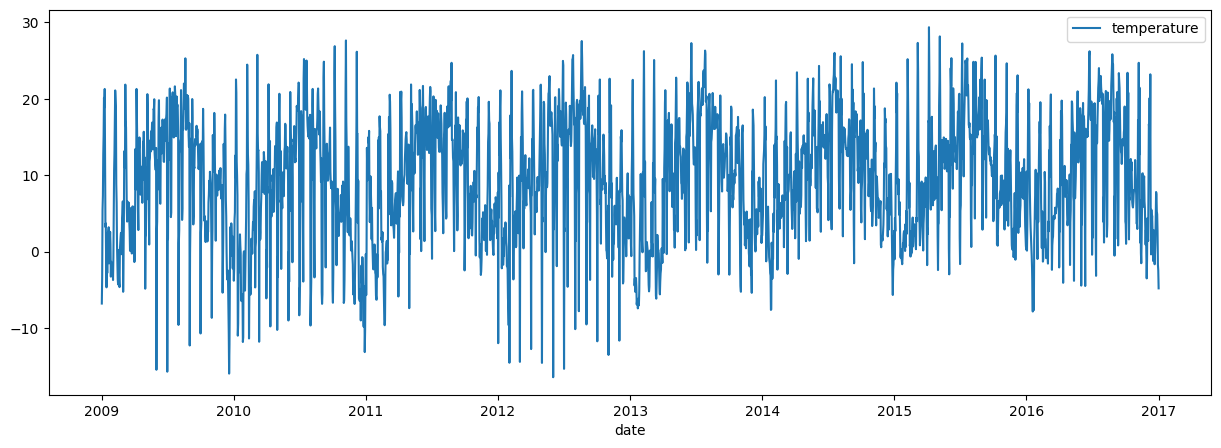

In [11]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df)
# only plot the first 3 years
# plt.xlim([df.index[0], df.index[365*3]])

In [12]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [13]:
train, test = split_data(df)
print(len(train), len(test))

2485 438


In [14]:
def slideWindow(df, window_in, horizon):
    d = df.values
    X, y = [], []
    idx = df.index[:-window_in]

    for start in range(len(df)-window_in):
        end = start + window_in
        out = end + horizon
        X.append(d[start:end].reshape(-1))
        y.append(d[end:out].ravel())
    
    cols_x = [f'x{i}' for i in range(1, window_in+1)]
    cols_y = [f'y{i}' for i in range(1, horizon+1)]
    df_xs = pd.DataFrame(X, index=idx, columns=cols_x)
    df_y = pd.DataFrame(y, index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [15]:
win_in = 6 # the number of lag variables
HORIZON = 1 # predict oe step ahead: next day temperature
train_shift = slideWindow(train, win_in, HORIZON)
test_shift = slideWindow(test, win_in, HORIZON)

X_train = train_shift.iloc[:, :-1] # all columns except the last one
y_train = train_shift.iloc[:, -1:] # the last column

X_test = test_shift.iloc[:, :-1]
y_test = test_shift.iloc[:, -1:]

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2479, 6), (2479, 1), (432, 6), (432, 1))

In [20]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
#import desicion tree regressor, k nearest neighbors regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


algs = {
    'Linear Regression': LinearRegression(),
    'Bagging': BaggingRegressor(n_estimators=50, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
    'SVM': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor()
}

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
listScores = []
for name, alg in algs:

    regress = alg.fit(X_train, y_train)
    y_pred = regress.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    score = alg.score(X_test, y_test)
    listScores.append([name, score])

IndexError: index 1095 is out of bounds for axis 0 with size 430

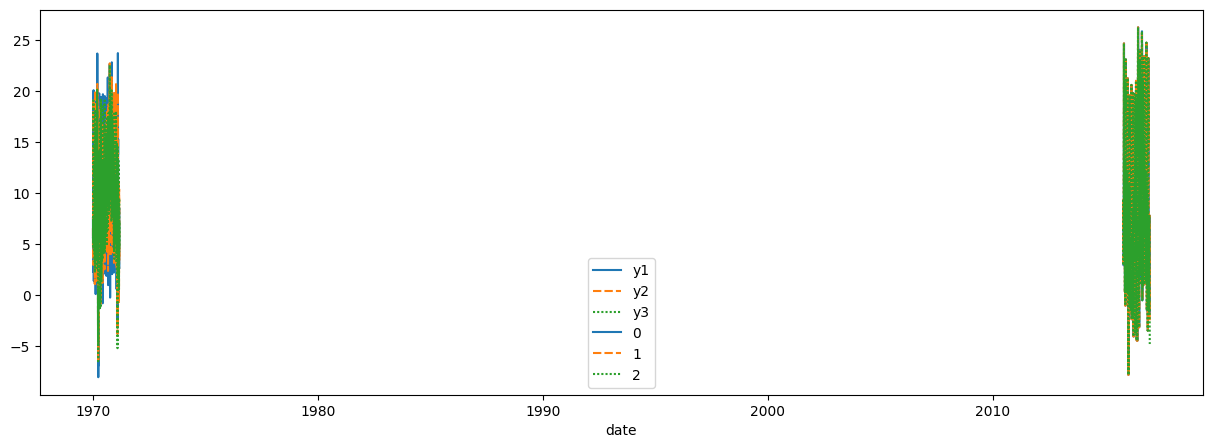

In [24]:
alg = RandomForestRegressor(n_estimators=50, random_state=42) # this is the best regressor
regress = alg.fit(X_train, y_train)
y_pred = regress.predict(X_test)

# TODO jak to plotnout??

# Multi-step forecasting

In [18]:
win_in = 6
HORIZON = 3

train_shift = slideWindow(train, win_in, HORIZON)
test_shift = slideWindow(test, win_in, HORIZON)

X_train = train_shift.iloc[:, :-HORIZON]
y_train = train_shift.iloc[:, -HORIZON:]

X_test = test_shift.iloc[:, :-HORIZON]
y_test = test_shift.iloc[:, -HORIZON:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2477, 6) (2477, 3) (430, 6) (430, 3)


In [ ]:
alg = RandomForestRegressor(n_estimators=50, random_state=42)
regress = alg.fit(X_train, y_train)
y_pred = regress.predict(X_test)

